In [1]:
import pandas as pd 
import numpy as np
import math
from utlis import *


tmp = pd.read_csv('Weed_Resistance_Data.csv', sep = ',', header=None)
params_in = list(tmp[:21][0])


params_in = np.array(params_in)

In [2]:
General_TillingFrequency = np.loadtxt('Corteva/BMP_Matlab_Code/Tilling_Data.txt')
Herbicide_data = np.loadtxt('Corteva/BMP_Matlab_Code/Herbicide_Data.txt')

In [3]:
from utlis import PrepareParams
import numpy as np 
from scipy import integrate




a = 1
Params = PrepareParams()

nYears = int(Params.General.nYears)
nCohorts = int(Params.General.nCohorts)

# nYears = 25
# nCohorts = 2
print("starting year and cohort are: ", nYears, " & ", nCohorts)

H1_eff = [.99,.5,.1]
H2_eff = [.9,.8,.2]
H3_eff = [0,0,0]
H4_eff = [0,0,0]

strategies = []
overall = []
risk_integral_all = []


for i in range(50):
    Population.seedBank = np.zeros((nYears,nGeno,nCohorts))
    # %Lower seed bank density
    Population.lowerBank = np.zeros((nYears,nGeno))
    # %immigrant seed
    Population.immSeed = np.zeros((nYears,nGeno,nCohorts))
    # %emigrant seed
    Population.emSeed = np.zeros((nYears,nGeno,nCohorts))
    # %germination storage
    Population.germination = np.zeros((nYears,nGeno,nCohorts))
    # %ungerminated storage
    Population.ungerminated = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide1 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide2 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide3 = np.zeros((nYears,nGeno,nCohorts))
    Population.herbicide4 = np.zeros((nYears,nGeno,nCohorts))
    Population.seedProd = np.zeros((nYears,nGeno,nCohorts))
    Population.mature = np.zeros((nYears,nGeno,nCohorts))
    Population.hand = np.zeros((nYears,nGeno,nCohorts))
    Population.immPol = np.zeros((nYears,nGeno,nCohorts))
    Population.emPol = np.zeros((nYears,nGeno,nCohorts))
    Population.newSeed = np.zeros((nYears,nGeno,nCohorts))
    Population.mutated = np.zeros((nYears,nGeno,nCohorts))
    Population.predation = np.zeros((nYears,nGeno,nCohorts))
    Population.winter = np.zeros((nYears,nGeno))
    Population.Res = np.zeros((1, 3))
    Population.seedBank[0,:,0] = Params.General.UpperSeedBank
    Population.lowerBank[0,:] = Params.General.LowerSeedBank

    for y in range(nYears):
        tempSeedBank = np.zeros(81)
        Population.seedBank[y,:,0],Population.lowerBank[y,:] = deepTill(Population.seedBank[y,:,0],
                                                                    Population.lowerBank[y,:],
                                                                    Params.General.TillingFreq,y)

        for c in range(nCohorts):
            # print(" y : ", y, " c", c)
            
            ImmSeed = seedImmigration(nGeno)
            seedBank = Population.seedBank[y,:,c]+ ImmSeed
            seedBank = extinction(seedBank,fieldSize)
            fGerm = Params.Germination.survivalFraction[0,0]
            germination = survival(seedBank,fGerm)
            ungerminated = seedBank - germination
            germination = extinction(germination,fieldSize)
            fCult = Params.Cultivation.survivalFraction[y,c]
            cult = survival(germination,fCult)
            cult = extinction(cult,fieldSize)

            # fSS = 1 - Params.Herbicide1.efficacy_SS[0,0]
            # fRS = 1 - Params.Herbicide1.efficacy_RS[0,0]
            # fRR = 1 - Params.Herbicide1.efficacy_RR[0,0]

            fSS = 1 - H1_eff[0]
            fRS = 1 - H1_eff[1]
            fRR = 1 - H1_eff[2]

            targetLocus = Params.Herbicide1.targetLocus

            herbicide1_ = selectiveSurvival(cult,[fSS,fRS,fRR],targetLocus,Params.key)

            herbicide1 = extinction(herbicide1_,fieldSize)

            # fSS = 1 - Params.Herbicide2.efficacy_SS[y,c]
            # fRS = 1 - Params.Herbicide2.efficacy_RS[y,c]
            # fRR = 1 - Params.Herbicide2.efficacy_RR[y,c]

            fSS = 1 - H2_eff[0]
            fRS = 1 - H2_eff[1]
            fRR = 1 - H2_eff[2]

            targetLocus = Params.Herbicide2.targetLocus

            herbicide2 = selectiveSurvival(herbicide1,[fSS,fRS,fRR],targetLocus,Params.key)
                    
            herbicide2 = extinction(herbicide2,fieldSize)

            fSS = 1 - H3_eff[0]
            fRS = 1 - H3_eff[1]
            fRR = 1 - H3_eff[2]

            targetLocus = Params.Herbicide3.targetLocus

            herbicide3 = selectiveSurvival(herbicide2,[fSS,fRS,fRR],targetLocus,Params.key)
            herbicide3 = extinction(herbicide3,fieldSize)

            fSS = 1 - H4_eff[0]
            fRS = 1 - H4_eff[1]
            fRR = 1 - H4_eff[2]

            targetLocus = Params.Herbicide4.targetLocus

            herbicide4 = selectiveSurvival(herbicide3,[fSS,fRS,fRR],targetLocus,Params.key)
            herbicide4 = extinction(herbicide4,fieldSize)

            A = Params.Mature.maxplants[y,c]
            B = Params.Mature.cropParam[y,c]
            C = Params.Mature.weedCompetition[y,c]

            mature = competition(herbicide4,A,B,C)
            mature = extinction(mature,fieldSize)
            fHand = Params.Hand.survivalFraction[y,c]

            hand = survival(mature,fHand)
            hand = extinction(hand,fieldSize)
            
            A = Params.SeedProd.maxyield[y,c]
            B = Params.SeedProd.cropParam[y,c]
            C = Params.SeedProd.weedCompetition[y,c]

            sum_hand = float(np.sum(hand))
            seedYield = competition(sum_hand,A,B,C)
            
            newFrac = mating(hand,Params.General.selfingCoeff, Params.key)
            seedProd= newFrac*seedYield*Params.General.femaleFrac
            seedProd = extinction(seedProd,fieldSize)

            targetLocus = 1
            muS2R = Params.Mutation.muS2R_locus1[y,c]
            muR2S = Params.Mutation.muR2S_locus1[y,c]
        
            if muS2R==0 and muR2S==0:
                mutated_locus1 = seedProd
            else:
                mutated_locus1 = mutation(seedProd,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus1 = extinction(mutated_locus1,fieldSize)

            targetLocus = 2
            muS2R = Params.Mutation.muS2R_locus2[y,c]
            muR2S = Params.Mutation.muR2S_locus2[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus2 = mutated_locus1
            else:
                mutated_locus2 = mutation(mutated_locus1,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus2 = extinction(mutated_locus2,fieldSize)

            targetLocus = 3
            muS2R = Params.Mutation.muS2R_locus3[y,c]
            muR2S = Params.Mutation.muR2S_locus3[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus3 = mutated_locus2
            else:
                mutated_locus3 = mutation(mutated_locus2,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus3 = extinction(mutated_locus3,fieldSize)

            targetLocus = 4
            muS2R = Params.Mutation.muS2R_locus4[y,c]
            muR2S = Params.Mutation.muR2S_locus4[y,c]

            if muS2R==0 and muR2S==0:
                mutated_locus4 = mutated_locus3
            else:
                mutated_locus4 = mutation(mutated_locus3,muS2R,muR2S,targetLocus,Params.key)
                mutated_locus4 = extinction(mutated_locus4,fieldSize)

            fPred = Params.Predation.survivalFraction[y,c]
            predation = survival(mutated_locus4,fPred)
            predation = extinction(predation,fieldSize)


            # print(predation) 
            if Params.General.seedDelay == 0:
                if c < nCohorts-1:
                    Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + predation + ungerminated
                else:
                    tempSeedBank = tempSeedBank + ungerminated + predation
            else:
                tempSeedBank = tempSeedBank + predation
                if c < nCohorts:

                    Population.seedBank[y,:,c+1] = Population.seedBank[y,:,c+1] + ungerminated
                else:
                    tempSeedBank = tempSeedBank + ungerminated

            Population.immSeed[y,:,c] = ImmSeed
            Population.ungerminated[y,:,c] = ungerminated
            Population.germination[y,:,c] = germination
            Population.herbicide1[y,:,c] = herbicide1
            Population.herbicide2[y,:,c] = herbicide2
            # Population.herbicide3[y,:,c] = herbicide3
            # Population.herbicide4[y,:,c] = herbicide4
            Population.mature[y,:,c] = mature
            Population.hand[y,:,c] = hand
            Population.seedProd[y,:,c] = seedProd
            Population.predation[y,:,c] = predation
            
        if y != nYears-1:
            fWint_upper = Params.Winter.uppersurvivalFraction[y][c]
            fWint_lower = Params.Winter.lowersurvivalFraction[y][c]

            winter_ = survival(tempSeedBank,fWint_upper)
            winter = extinction(winter_,fieldSize)

            Population.winter[y,:] = winter
            Population.seedBank[y+1,:,0] = Population.seedBank[y+1,:,0] + winter
            Population.lowerBank[y+1,:] = survival(Population.lowerBank[y,:],fWint_lower)
            Population.lowerBank[y+1,:] = extinction(Population.lowerBank[y+1,:],fieldSize)

        else:
            break
        N = nYears*nCohorts

    newPop = np.zeros((N,nGeno))

    k = 0
    for y in range(nYears):
        for c in range(nCohorts):
            newPop[k,:] = Population.seedBank[y,:,c]
            k = k + 1


    Rpop = np.zeros(nYears*nCohorts,)
    for G in range(nGeno):
        for L in range(nLoci):
            if Params.key[L,G] == 2 or Params.key[L,G] == 1:
                Rpop =  Rpop + newPop[:,G]
                break
            
    pltPop = Rpop/np.sum(newPop, axis=1)
    # print(pltPop.shape)

    if sum(pltPop[-5:-1]) > .2:
        strategies.append(pltPop)
        overall.append(pltPop)
        risk_integral_all.append(integrate.trapezoid(pltPop)/N)
        
        a+=1
        if a % 20 == 0 or i == 999:
            print("total fish caught: ", a)
    else:
        overall.append(pltPop)
        risk_integral_all.append(integrate.trapezoid(pltPop)/N)




starting year and cohort are:  25  &  2


In [4]:
np.sum(newPop, axis=1)

array([1.00000000e+00, 2.00334256e+00, 2.80936297e+00, 5.62810876e+00,
       7.89249910e+00, 1.58113179e+01, 2.21726668e+01, 4.44189590e+01,
       6.22890999e+01, 1.24782544e+02, 1.74976673e+02, 3.50507725e+02,
       4.91445276e+02, 9.84292706e+02, 1.37963767e+03, 2.76199263e+03,
       3.86794461e+03, 7.73396342e+03, 1.08042228e+04, 2.15294093e+04,
       2.98746628e+04, 5.89842200e+04, 8.04172130e+04, 1.55114284e+05,
       2.02886678e+05, 3.72036544e+05, 4.50305315e+05, 7.60411032e+05,
       8.31762785e+05, 1.28047868e+06, 1.27845731e+06, 1.82401154e+06,
       1.70639531e+06, 2.30858634e+06, 2.06980642e+06, 2.70332290e+06,
       2.35800044e+06, 3.00886931e+06, 2.57765192e+06, 3.23836375e+06,
       2.74109083e+06, 3.40756365e+06, 2.86087710e+06, 3.53083402e+06,
       2.94780965e+06, 3.61994020e+06, 3.01048625e+06, 3.68401104e+06,
       3.05547370e+06, 3.72991415e+06])

In [5]:
np.mean([i for i in risk_integral_all if i > .001])

0.9406472384361159

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


strategies = np.array(strategies)
strategy = np.mean(strategies, axis=0)

dev = np.std(strategies, axis = 0)



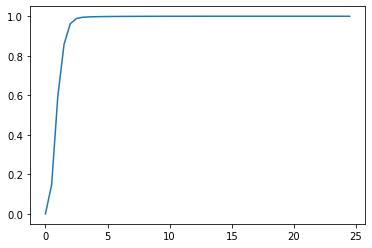

In [12]:
x = np.array([i for i in range(len(strategy))])/nCohorts
y = strategy


# plt.plot(x,np.sum(newPop, axis=1))
plt.plot(x,y)


In [ ]:
from scipy import integrate

auc = integrate.trapezoid(y)
auc

19.37912545040018

In [ ]:
result_dict = {}
avg_std = {}
avg_std['average'] = strategy
avg_std['std'] = dev

# molecule = {}

# dose = {}

# dose['combined'] = avg_std

# molecule['x713'] = dose





import pickle as pkl
# create a binary pickle file 
# f = open("x713_25_50.pkl","wb")
f = pkl.load( open( "all_4.pkl", "rb" ) )

f['combined'] = avg_std
## write the python object (dict) to pickle file
pkl.dump( f, open( "all_4_nd_combined.pkl", "wb" ) )

# close file
# f.close()







(-0.1, 1.1)

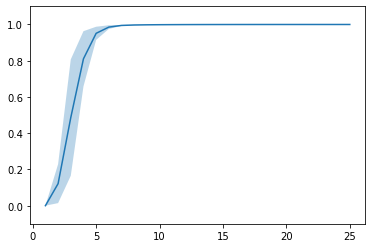

In [ ]:
lower = strategy - dev
upper = strategy + dev 



plt.fill_between([x+1 for x in range(len(strategy))], lower, upper, alpha=.3)
plt.plot([x+1 for x in range(len(strategy))], strategy)
plt.ylim([-0.10,1.1])

In [ ]:
import pickle as pkl
f = pkl.load( open( "all_4_nd_combined.pkl", "rb" ) )
f

{'x713': {'25_50': {'average': array([1.99999999e-08, 9.16361248e-04, 1.64762731e-03, 2.84014801e-03,
          4.15163266e-03, 5.68638872e-03, 7.53808584e-03, 9.80721226e-03,
          1.26105428e-02, 1.60871422e-02, 2.04032084e-02, 2.57561177e-02,
          3.23773182e-02, 4.05332640e-02, 5.05232175e-02, 6.26724753e-02,
          7.73195354e-02, 9.47960880e-02, 1.15399665e-01, 1.39360376e-01,
          1.66805194e-01, 1.97725146e-01, 2.31951810e-01, 2.69148976e-01,
          3.08823042e-01]),
   'std': array([0.        , 0.00029688, 0.00053228, 0.00091636, 0.00133731,
          0.00182802, 0.00241731, 0.00313532, 0.00401609, 0.00509876,
          0.00642799, 0.00805371, 0.01002965, 0.01241054, 0.01524715,
          0.01857905, 0.02242476, 0.02676999, 0.03155546, 0.03666717,
          0.04193254, 0.04712629, 0.05198797, 0.05624993, 0.05967112])},
  '50_81': {'average': array([1.99999999e-08, 9.75363102e-04, 3.56520063e-03, 1.26205261e-02,
          3.22463787e-02, 6.48713168e-02, 1.09

In [ ]:
f

{'x713': {'25_50': {'average': array([1.99999999e-08, 9.16361248e-04, 1.64762731e-03, 2.84014801e-03,
          4.15163266e-03, 5.68638872e-03, 7.53808584e-03, 9.80721226e-03,
          1.26105428e-02, 1.60871422e-02, 2.04032084e-02, 2.57561177e-02,
          3.23773182e-02, 4.05332640e-02, 5.05232175e-02, 6.26724753e-02,
          7.73195354e-02, 9.47960880e-02, 1.15399665e-01, 1.39360376e-01,
          1.66805194e-01, 1.97725146e-01, 2.31951810e-01, 2.69148976e-01,
          3.08823042e-01]),
   'std': array([0.        , 0.00029688, 0.00053228, 0.00091636, 0.00133731,
          0.00182802, 0.00241731, 0.00313532, 0.00401609, 0.00509876,
          0.00642799, 0.00805371, 0.01002965, 0.01241054, 0.01524715,
          0.01857905, 0.02242476, 0.02676999, 0.03155546, 0.03666717,
          0.04193254, 0.04712629, 0.05198797, 0.05624993, 0.05967112])},
  '50_81': {'average': array([1.99999999e-08, 9.75363102e-04, 3.56520063e-03, 1.26205261e-02,
          3.22463787e-02, 6.48713168e-02, 1.09